/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
✅ RMSE: 3.1514


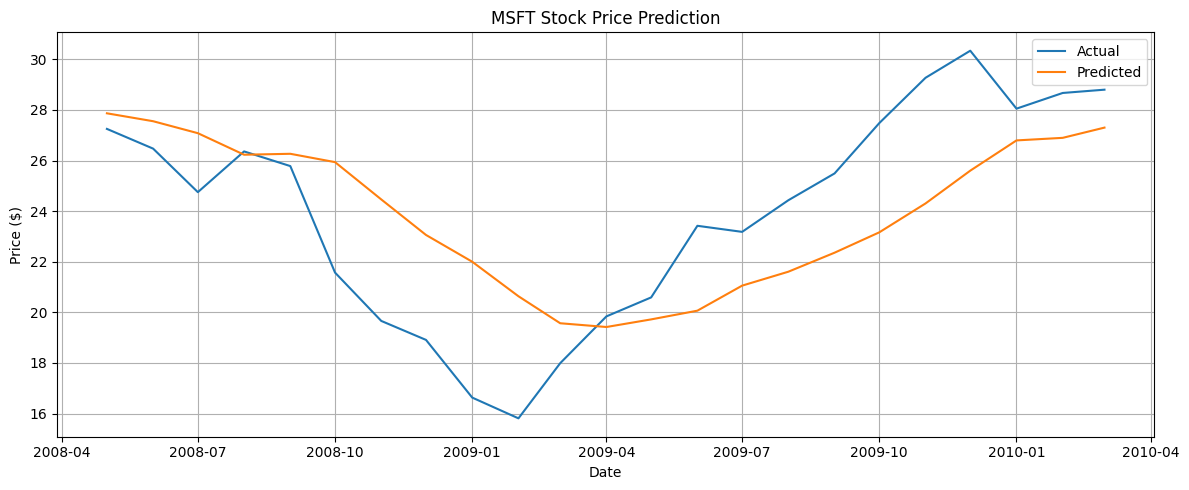

In [2]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import math

# 📥 Load your dataset
df = pd.read_csv("stocks.csv")

# 🧹 Preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df[df['symbol'] == 'MSFT']
df = df.sort_values('date')
df = df.reset_index(drop=True)

# 🧠 Normalize
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['price']])

# 🔁 Create windowed dataset
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12  # use past 12 months
X, y = create_sequences(scaled_prices, window_size)

# 🧪 Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 🏗️ Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# 📈 Predict & Inverse Scale
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 📉 RMSE
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("✅ RMSE:", round(rmse, 4))

# 📊 Plot
plt.figure(figsize=(12, 5))
plt.plot(df['date'][-len(y_test):], y_test_inv, label="Actual")
plt.plot(df['date'][-len(y_test):], y_pred_inv, label="Predicted")
plt.title("MSFT Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
